The most common ways to finetune language models are instruction finetuning and classification finetuning. Instruction finetuning involves training a language model on a set of tasks using specific instructions to improve its ability to understand and execute tasks described in natural language prompts.
In classification finetuning, the model is trained to recognize a specific set of class labels such as "spam" or "not spam". examples go beyond email filtering; they include identifying between different species of plants or animals; categorizing news articles into sports, entertainment, politics etc.
Usually an instruction finetuned model can undergo a broader range of tasks.

Instruction fine-tuning improves a model’s ability to understand and generate responses
based on specific user instructions. Instruction fine-tuning is best suited for models
that need to handle a variety of tasks based on complex user instructions, improving
flexibility and interaction quality. Classification fine-tuning is ideal for projects requiring precise categorization of data into predefined classes, such as sentiment analysis or spam detection.
While instruction fine-tuning is more versatile, it demands larger datasets and greater
computational resources to develop models proficient in various tasks. In contrast,
classification fine-tuning requires less data and compute power, but its use is confined to the specific classes on which the model has been trained.

### Preparing the dataset

In [1]:
import urllib.request
import zipfile
import os
from pathlib import Path

url = "https://archive.ics.uci.edu/static/public/228/sms+spam+collection.zip"
zip_path = "sms_spam_collection.zip"
extract_dir = "sms_spam_data"
data_file_path = Path(extract_dir) / "SMSSpamCollection.tsv"

# Download the dataset
def download_and_unzip_spam_data(url, zip_path, extract_dir, data_file_path):
    if data_file_path.exists():
        print(f"Data file already exists at {data_file_path}. Skipping download.")
        return
    with urllib.request.urlopen(url) as response:
        with open(zip_path, 'wb') as out_file:
            out_file.write(response.read())
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        zip_ref.extractall(extract_dir)
    original_file_path = Path(extract_dir) / "SMSSpamCollection"
    os.rename(original_file_path, data_file_path)
    print(f"Data downloaded and extracted to {data_file_path}.")

download_and_unzip_spam_data(url, zip_path, extract_dir, data_file_path)
    

Data file already exists at sms_spam_data/SMSSpamCollection.tsv. Skipping download.


In [2]:
import pandas as pd
# Load the dataset into a DataFrame
df = pd.read_csv(data_file_path, sep='\t', header=None, names=['Label', 'Text'])
print(df.head())

  Label                                               Text
0   ham  Go until jurong point, crazy.. Available only ...
1   ham                      Ok lar... Joking wif u oni...
2  spam  Free entry in 2 a wkly comp to win FA Cup fina...
3   ham  U dun say so early hor... U c already then say...
4   ham  Nah I don't think he goes to usf, he lives aro...


In [3]:
print(df['Label'].value_counts())

Label
ham     4825
spam     747
Name: count, dtype: int64


we need to balance the dataset so we can have 747 instances for both classes

In [4]:
def create_balanced_dataset(df):
    num_spam = df[df['Label'] == 'spam'].shape[0]
    ham_df = df[df['Label'] == 'ham'].sample(n=num_spam, random_state=123)
    balanced_df = pd.concat([ham_df, df[df['Label'] == 'spam']])
    return balanced_df
balanced_df = create_balanced_dataset(df)
print(balanced_df['Label'].value_counts())

Label
ham     747
spam    747
Name: count, dtype: int64


next we convert the string class labels into integer class labels

In [5]:
balanced_df['Label'] = balanced_df['Label'].map({'ham': 0, 'spam': 1})

next we split out data into training, test and validation sets

In [6]:
def random_split(df, train_frac, validation_frac):
    
    df = df.sample(frac=1, random_state=123).reset_index(drop=True)  # Shuffle the DataFrame
    train_end = int(len(df) * train_frac)
    validation_end = train_end + int(len(df) * validation_frac)
    
    train_df = df.iloc[:train_end]
    validation_df = df.iloc[train_end:validation_end]
    test_df = df.iloc[validation_end:]
    return train_df, validation_df, test_df

train_df, validation_df, test_df = random_split(balanced_df, 0.7, 0.1)

train_df.to_csv("train_data.csv", index=None)
validation_df.to_csv("validation_data.csv", index=None)
test_df.to_csv("test_data.csv", index=None)

creating dataloaders by padding all messages to the length of the longest message in the dataset or batch. to do this we add padding tokens (<|endoftext|>) to all shorter messages. instead of just adding the string "<|endoftext|>" directly, we will add the token id corresponding to "<|endoftext|>" to the encoded text messages.

In [7]:
# checking the encoding for <|endoftext|>

import tiktoken
tokenizer = tiktoken.get_encoding("gpt2")
print(tokenizer.encode("<|endoftext|>", allowed_special={"<|endoftext|>"})) 

# the answer is [50256] which is the special token for end of text

[50256]


In [8]:
import torch
from torch.utils.data import Dataset


class SpamDataset(Dataset):
    def __init__(self, csv_file, tokenizer, max_length=None, pad_token_id=50256):
        self.data = pd.read_csv(csv_file)
        self.encoded_texts = [tokenizer.encode(text) for text in self.data["Text"]]
        if max_length is None:
            self.max_length = self._longest_encoded_length()
        else:
            self.max_length = max_length

            self.encoded_texts = [
                encoded_text[: self.max_length] for encoded_text in self.encoded_texts
            ]
        self.encoded_texts = [
            encoded_text + [pad_token_id] * (self.max_length - len(encoded_text))
            for encoded_text in self.encoded_texts
        ]

    def __getitem__(self, index):
        encoded = self.encoded_texts[index]
        label = self.data.iloc[index]["Label"]
        return (
            torch.tensor(encoded, dtype=torch.long),
            torch.tensor(label, dtype=torch.long),
        )

    def __len__(self):
        return len(self.data)

    def _longest_encoded_length(self):
        max_length = 0
        for encoded_text in self.encoded_texts:
            encoded_length = len(encoded_text)
            if encoded_length > max_length:
                max_length = encoded_length
        return max_length


In [9]:
train_dataset = SpamDataset(
    csv_file="train_data.csv",
    tokenizer=tokenizer,
    max_length=None
)

In [10]:
print(train_dataset.max_length)

120


the longest sequence contain no more than 120 tokens which is common for text messages

In [11]:
val_dataset = SpamDataset(
    csv_file="validation_data.csv",
    tokenizer=tokenizer,
    max_length=train_dataset.max_length
)
test_dataset = SpamDataset(
    csv_file="test_data.csv",
    tokenizer=tokenizer,
    max_length=train_dataset.max_length
)

In [12]:
from torch.utils.data import DataLoader

num_workers = 0
batch_size = 8
torch.manual_seed(123)

train_loader = DataLoader(
    dataset=train_dataset,
    batch_size=batch_size,
    shuffle=True,
    num_workers=num_workers,
    drop_last=True,
)
val_loader = DataLoader(
    dataset=val_dataset,
    batch_size=batch_size,
    num_workers=num_workers,
    drop_last=True,
)
test_loader = DataLoader(
    dataset=test_dataset,
    batch_size=batch_size,
    num_workers=num_workers,
    drop_last=False,
)

In [13]:
# to ensure our dataloaders are working correctly, we iterate over the training loader and then break after the first batch
for input_batch, target_batch in train_loader:
    pass
print("Input batch shape:", input_batch.shape)
print("Target batch shape:", target_batch.shape)

Input batch shape: torch.Size([8, 120])
Target batch shape: torch.Size([8])


In [14]:
print(f"{len(train_loader)} training batches")
print(f"{len(val_loader)} validation batches")
print(f"{len(test_loader)} test batches")


130 training batches
18 validation batches
38 test batches


In [15]:
CHOOSE_MODEL = "gpt2-small (124M)"
INPUT_PROMPT = "Every effort moves"

BASE_CONFIG = {
    "vocab_size": 50257,
    "context_length": 1024,
    "drop_rate": 0.0,
    "qkv_bias": True,
}
model_configs = {
    "gpt2-small (124M)": {"emb_dim": 768, "n_layers": 12, "n_heads": 12},
    "gpt2-medium (355M)": {"emb_dim": 1024, "n_layers": 24, "n_heads": 16},
    "gpt2-large (774M)": {"emb_dim": 1280, "n_layers": 36, "n_heads": 20},
    "gpt2-xl (1558M)": {"emb_dim": 1600, "n_layers": 48, "n_heads": 25},
}
BASE_CONFIG.update(model_configs[CHOOSE_MODEL])

In [16]:
from safetensors.torch import load_file
import sys
import os

ch04_path = os.path.abspath("LLMs-from-scratch/ch04/01_main-chapter-code")

if ch04_path not in sys.path:
    sys.path.append(ch04_path)
from gpt import GPTModel

model = GPTModel(BASE_CONFIG)

model.load_state_dict(load_file("./gpt2/124M/gpt2-small-124M.safetensors"))

<All keys matched successfully>

In [17]:
pkg_path = os.path.abspath("LLMs-from-scratch/pkg")

# Add to sys.path if not already present
if pkg_path not in sys.path:
    sys.path.append(pkg_path)
from llms_from_scratch.ch05 import load_weights_into_gpt

In [18]:
from llms_from_scratch.ch04 import generate_text_simple
from llms_from_scratch.ch05 import text_to_token_ids, token_ids_to_text

text_1 = "Every effort moves you"
token_ids = generate_text_simple(
    model=model,
    idx=text_to_token_ids(text_1, tokenizer),
    max_new_tokens=15,
    context_size=BASE_CONFIG["context_length"],
)
print(token_ids_to_text(token_ids, tokenizer))


Every effort moves you forward.

The first step is to understand the importance of your work


In [19]:
text_2 = (
    "Is the following text 'spam'? Answer with 'yes' or 'no': "
    "You are a winner you have been specially"
    " selected to receive a $1000 Walmart gift card. Click here to claim now."
)
token_ids = generate_text_simple(
    model=model,
    idx=text_to_token_ids(text_2, tokenizer),
    max_new_tokens=23,
    context_size=BASE_CONFIG["context_length"],
)
print(token_ids_to_text(token_ids, tokenizer))

Is the following text 'spam'? Answer with 'yes' or 'no': You are a winner you have been specially selected to receive a $1000 Walmart gift card. Click here to claim now.

You have been specially selected to receive a $1000 Walmart gift card. Click here to claim now.



the model is currently struggling to follow instructions, so now we need to do more work to prepare the model for classification finetuning by adding a classification head

In [20]:
print(model)

GPTModel(
  (tok_emb): Embedding(50257, 768)
  (pos_emb): Embedding(1024, 768)
  (drop_emb): Dropout(p=0.0, inplace=False)
  (trf_blocks): Sequential(
    (0): TransformerBlock(
      (att): MultiHeadAttention(
        (W_query): Linear(in_features=768, out_features=768, bias=True)
        (W_key): Linear(in_features=768, out_features=768, bias=True)
        (W_value): Linear(in_features=768, out_features=768, bias=True)
        (out_proj): Linear(in_features=768, out_features=768, bias=True)
        (dropout): Dropout(p=0.0, inplace=False)
      )
      (ff): FeedForward(
        (layers): Sequential(
          (0): Linear(in_features=768, out_features=3072, bias=True)
          (1): GELU()
          (2): Linear(in_features=3072, out_features=768, bias=True)
        )
      )
      (norm1): LayerNorm()
      (norm2): LayerNorm()
      (drop_shortcut): Dropout(p=0.0, inplace=False)
    )
    (1): TransformerBlock(
      (att): MultiHeadAttention(
        (W_query): Linear(in_features=7

to get the model ready for finetuning, we first freeze the model meaning we make all layers untrainable

In [21]:
for param in model.parameters():
    param.requires_grad = False

In [22]:
torch.manual_seed(123)
num_classes = 2
model.out_head = torch.nn.Linear(
    in_features=BASE_CONFIG["emb_dim"], out_features=num_classes
)

In [23]:
for param in model.trf_blocks[-1].parameters():
    param.requires_grad = True
for param in model.final_norm.parameters():
    param.requires_grad = True

Calculating the classification loss and accuracy

In [24]:
def calc_accuracy_loader(data_loader, model, device, num_batches=None):
    model.eval()
    correct_predictions, num_examples = 0, 0
    
    if num_batches is None:
        num_batches = len(data_loader)
    else:
        num_batches = min(num_batches, len(data_loader))
    for i, (input_batch, target_batch) in enumerate(data_loader):
        if i < num_batches:
            input_batch = input_batch.to(device)
            target_batch = target_batch.to(device)
        
            with torch.no_grad():
                logits = model(input_batch)[:, -1, :]
            predicted_labels = torch.argmax(logits, dim=-1)
        
            num_examples += predicted_labels.shape[0]
            correct_predictions += ((predicted_labels == target_batch).sum().item())
        else:
            break
    return correct_predictions / num_examples
        
        


In [25]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

torch.manual_seed(123)
train_accuracy = calc_accuracy_loader(train_loader, model, device, num_batches=10)
val_accuracy = calc_accuracy_loader(val_loader, model, device, num_batches=10)
test_accuracy = calc_accuracy_loader(test_loader, model, device, num_batches=10)
print(f"Train accuracy (first 10 batches): {train_accuracy*100:.2f}%")
print(f"Validation accuracy (first 10 batches): {val_accuracy*100:.2f}%")
print(f"Test accuracy (first 10 batches): {test_accuracy*100:.2f}%")

Train accuracy (first 10 batches): 46.25%
Validation accuracy (first 10 batches): 45.00%
Test accuracy (first 10 batches): 48.75%


to improve on these scores, we have to fine tune the model on our dataset. first we define the loss function to be used during training. the objective is to maximize the spam classification accuracy.

In [26]:
def calculate_loss_batch(input_batch, target_batch, model, device):
    input_batch = input_batch.to(device)
    target_batch = target_batch.to(device)
    logits = model(input_batch)[:, -1, :]
    if torch.isnan(logits).any() or torch.isinf(logits).any():
        print(f"NaN/Inf detected in logits. Min: {logits.min()}, Max: {logits.max()}")
    loss = torch.nn.functional.cross_entropy(logits, target_batch)
    return loss

In [27]:
## classification loss for all batches
def calculate_loss_loader(data_loader, model, device, num_batches=None):
    model.eval()
    total_loss = 0
    if len(data_loader) == 0:
        return float("nan")
    elif num_batches is None:
        num_batches = len(data_loader)
    else:
        num_batches = min(num_batches, len(data_loader))
    for i, (input_batch, target_batch) in enumerate(data_loader):
        if i < num_batches:
            loss = calculate_loss_batch(input_batch, target_batch, model, device)
            total_loss += loss.item()
        else:
            break
    return total_loss / num_batches

In [28]:
with torch.no_grad():
    train_loss = calculate_loss_loader(
        train_loader, model, device, num_batches=5
    )
    val_loss = calculate_loss_loader(val_loader, model, device, num_batches=5)
    test_loss = calculate_loss_loader(test_loader, model, device, num_batches=5)
print(f"Train loss: {train_loss:.3f}")
print(f"Validation loss: {val_loss:.3f}")
print(f"Test loss: {test_loss:.3f}")

Train loss: 2.453
Validation loss: 2.583
Test loss: 2.322


next we will implement a training function to fine tune our model. this means adding a loss function and optimizer and training the model on our data.
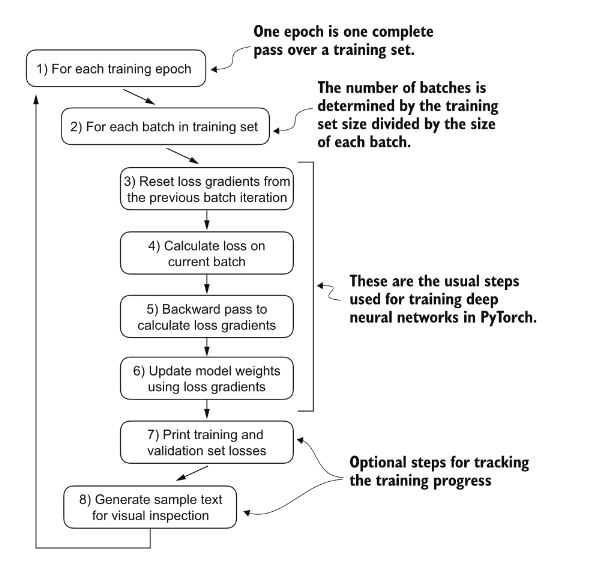

In [29]:
def train_classifier_simple(
    model,
    train_loader,
    val_loader,
    optimizer,
    num_epochs,
    eval_freq,
    device,
    eval_iter,
):
    train_losses, val_losses, train_accuracies, val_accuracies = [], [], [], []
    examples_seen, global_step = 0, -1

    for epoch in range(num_epochs):
        model.train()
    
        for input_batch, target_batch in train_loader:
            optimizer.zero_grad()
            loss = calculate_loss_batch(
                input_batch, target_batch, model, device
            )
            loss.backward()
            optimizer.step()
            examples_seen += input_batch.size(0)
            global_step += 1

            if global_step % eval_freq == 0:
                train_loss, val_loss = evaluate_model(
                    model, train_loader, val_loader, device, eval_iter
                )
                train_losses.append(train_loss)
                val_losses.append(val_loss)
                print(f"Epoch {epoch+1} (Step {global_step:06d}) : " f"Train Loss: {train_loss:.3f}, Val Loss: {val_loss:.3f}")
    train_accuracy = calc_accuracy_loader(
        train_loader, model, device, num_batches=eval_iter
    )
    val_accuracy = calc_accuracy_loader(
        val_loader, model, device, num_batches=eval_iter
    )
    print(f"Training accuracy: {train_accuracy*100:.2f}% | ", end="")
    print(f"Validation accuracy: {val_accuracy*100:.2f}%")
    train_accuracies.append(train_accuracy)
    val_accuracies.append(val_accuracy)
    return train_losses, val_losses, train_accuracies, val_accuracies, examples_seen

In [30]:
def evaluate_model(model, train_loader, val_loader, device, eval_iter):
    model.eval()
    with torch.no_grad():
        train_loss = calculate_loss_loader(
            train_loader, model, device, num_batches=eval_iter
        )
        val_loss = calculate_loss_loader(
            val_loader, model, device, num_batches=eval_iter
        )
    model.train()
    return train_loss, val_loss

In [33]:
import time

start_time = time.time()
torch.manual_seed(123)

optimizer = torch.optim.AdamW(model.parameters(), lr=5e-5, weight_decay=0.1)
num_epochs = 5

train_losses, val_losses, train_accuracies, val_accuracies, examples_seen = \
    train_classifier_simple(
        model,
        train_loader,
        val_loader,
        optimizer,
        num_epochs=num_epochs,
        device=device,
        eval_freq=50,
        eval_iter=5
    )
end_time = time.time()
execution_time_minutes = (end_time - start_time) / 60
print(f"Training took {execution_time_minutes:.2f} minutes.")

Epoch 1 (Step 000000) : Train Loss: 0.123, Val Loss: 0.070
Epoch 1 (Step 000050) : Train Loss: 0.056, Val Loss: 0.123
Epoch 1 (Step 000100) : Train Loss: 0.160, Val Loss: 0.065
Epoch 2 (Step 000150) : Train Loss: 0.053, Val Loss: 0.170
Epoch 2 (Step 000200) : Train Loss: 0.072, Val Loss: 0.046
Epoch 2 (Step 000250) : Train Loss: 0.049, Val Loss: 0.113
Epoch 3 (Step 000300) : Train Loss: 0.063, Val Loss: 0.122
Epoch 3 (Step 000350) : Train Loss: 0.162, Val Loss: 0.045
Epoch 4 (Step 000400) : Train Loss: 0.127, Val Loss: 0.104
Epoch 4 (Step 000450) : Train Loss: 0.009, Val Loss: 0.084
Epoch 4 (Step 000500) : Train Loss: 0.009, Val Loss: 0.087
Epoch 5 (Step 000550) : Train Loss: 0.007, Val Loss: 0.060
Epoch 5 (Step 000600) : Train Loss: 0.091, Val Loss: 0.081
Training accuracy: 97.50% | Validation accuracy: 97.50%
Training took 18.22 minutes.


plotting the classification loss

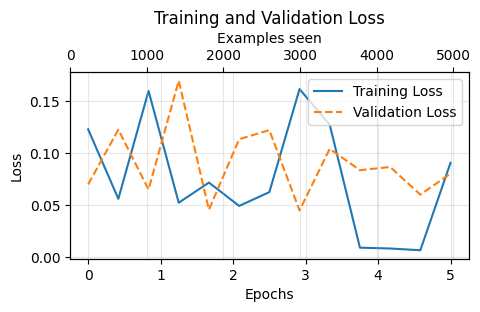

In [34]:
import matplotlib.pyplot as plt
import numpy as np

def plot_values(
    epochs_seen, examples_seen, train_values, val_values, label="Loss",
):
    fig, ax1 = plt.subplots(figsize=(5,3))

    ax1.plot(epochs_seen, train_values, label=f"Training {label}")
    ax1.plot(epochs_seen, val_values, linestyle="--", label=f"Validation {label}")
    ax1.set_xlabel("Epochs")
    ax1.set_ylabel(label.capitalize())
    ax1.legend()
    ax1.grid(alpha=0.3)

    ax2 = ax1.twiny()
    # Don't plot the raw examples_seen values (they can be large) because
    # plotting them on the shared y-axis will change the y-limits and
    # squash the loss curves. Instead set the top x-axis limits from
    # the examples_seen values.
    try:
        ex_vals = (
            examples_seen.numpy()
            if hasattr(examples_seen, "numpy")
            else np.array(examples_seen)
        )
        if ex_vals.size > 0:
            ax2.set_xlim(float(ex_vals.min()), float(ex_vals.max()))
    except Exception:
        pass
    ax2.set_xlabel("Examples seen")
    ax2.grid(alpha=0.3)

    fig.tight_layout()
    plt.savefig(f"{label.lower()}_plot.pdf")
    plt.title(f"Training and Validation {label}")
    plt.show()

epochs_tensor = torch.linspace(0, num_epochs, len(train_losses))
examples_seen_tensor = torch.linspace(0, examples_seen, len(train_losses))

plot_values(epochs_tensor, examples_seen_tensor, train_losses, val_losses)